## 1. A naive analysis

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn import linear_model
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [351]:
df0 = pd.read_csv("lalonde.csv", index_col='id')

df0 = df0.sort_values(by='treat', ascending=False) # ensuring that groups are well-formed (used this fact for matching)
df0['no degree'] = df0['nodegree']
df0 = df0.drop('nodegree', 1)
for col in ['black', 'hispan', 'married', 'no degree']:
    df0[col] = df0[col].map(lambda x: col if x == 1 else np.nan)
df0['black'].fillna(df0['hispan'], inplace=True)
df0['black'].fillna('white', inplace=True)
df0['race'] = pd.Categorical(df0['black'])
df0['married'].fillna('bachelor', inplace=True)
df0['married'] = pd.Categorical(df0['married'])
df0['no degree'].fillna('graduate', inplace=True)
df0['no degree'] = pd.Categorical(df0['no degree'])
df0 = df0.drop(['black', 'hispan'], 1)

df = df0

In [352]:
len(df0.index.unique())

614

In [353]:
len(df)

614

In [354]:
control = df[df['treat'] == 0].drop('treat', 1)
treat = df[df['treat'] == 1].drop('treat', 1)

 The data is not normally distributed since it's asymmetric. It is however positively skewed as shown in the boxplot and histograms. The QQ plots show a significant deviation from normality in the right tail (and also in the left tail, but that is trivial because the salary cannot be negative). This might hint to a power law since it is rare that workers have very high salaries but not so rare. However, the log-log plots show decreasing curves not lines. Also, we noticed that the control group is more than twice than the treatment group.
 
 We observe that the treatment was not effective according to the naive model. However, since this is an observational study, the treatment and control group are not comparable.

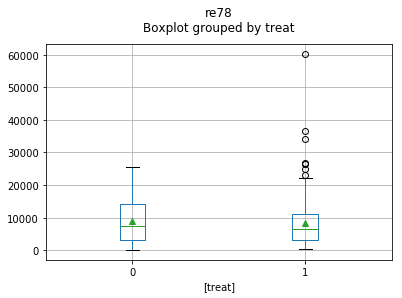

In [359]:
def boxplots(df, attr):
    proc_df = df[df[attr] > 0]
    ax = proc_df[['treat', attr]].boxplot(by='treat', showmeans=True)
    ttl = ax.title
    ttl.set_position([.5, 1.1])

boxplots(df, 're78')

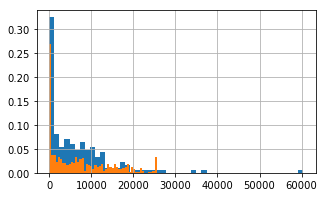

In [362]:
def plotHist(df, size=(5,3)):
    return df.hist(bins=50, weights=[1 / len(df)] * len(df), figsize=size)

plotHist(treat['re78'])
plotHist(control['re78'])

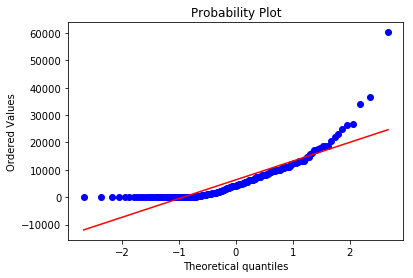

In [363]:
stats.probplot(treat['re78'], dist="norm", plot=matplotlib.pyplot)
plt.show()

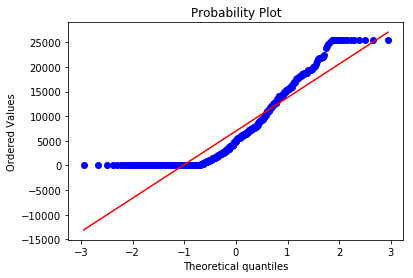

In [364]:
stats.probplot(control['re78'], dist="norm", plot=matplotlib.pyplot)
plt.show()

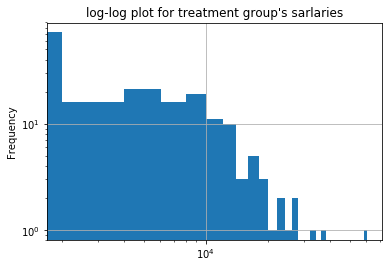

In [365]:
treat['re78'].plot(kind="hist", loglog=True, grid=True, bins=30, title="log-log plot for treatment group's sarlaries")

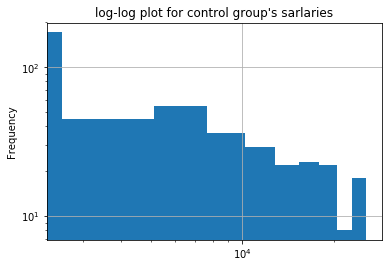

In [366]:
control['re78'].plot(kind="hist", loglog=True, grid=True, title="log-log plot for control group's sarlaries")

In [367]:
control[['re78']].describe()

,re78
count,429.000000
mean,6984.169742
std,7294.161791
min,0.000000
25%,220.181300
50%,4975.505000
75%,11688.820000
max,25564.670000


In [368]:
treat[['re78']].describe()

,re78
count,185.000000
mean,6349.143530
std,7867.402218
min,0.000000
25%,485.229800
50%,4232.309000
75%,9642.999000
max,60307.930000


## 2. A closer look at the data

As shown in the boxplots, the distribution of each feature is similar for both groups (with the exception of 'age', for which the treatment group has a slighlty lower average). This reflects the fact that subjects were offered a job training experience randomly. The histograms show that the salaries and the age are skewed distributions, indeed their qq-plots are arched with respect to the normal distribution. However, the feature 'education' seems to be close to a normal distribution on the other hand.

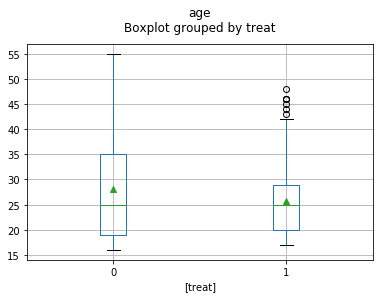

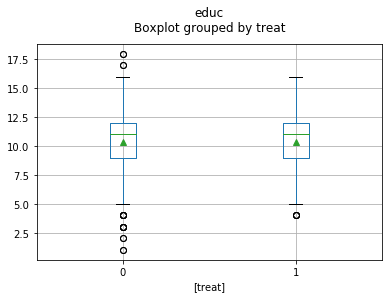

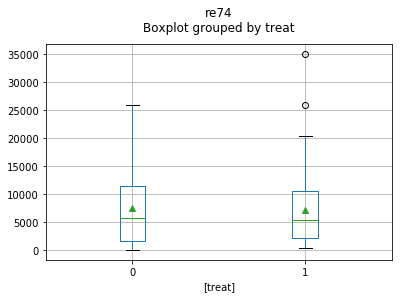

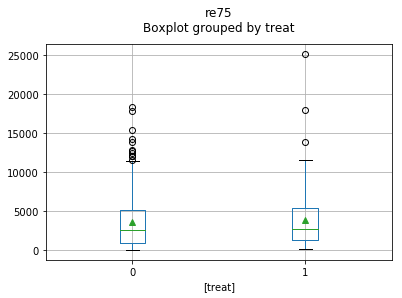

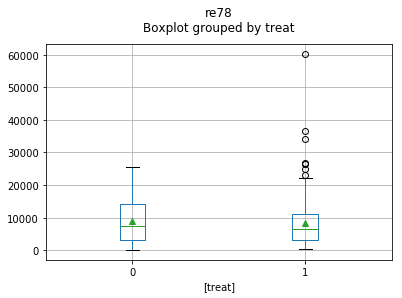

In [369]:
df = df0[['treat', 'age', 'educ', 're74', 're75', 're78']]
treat = df[df['treat'] == 1].drop('treat', 1)
control = df[df['treat'] == 0].drop('treat', 1)
for col in df.drop('treat', 1).columns:
    boxplots(df, col)

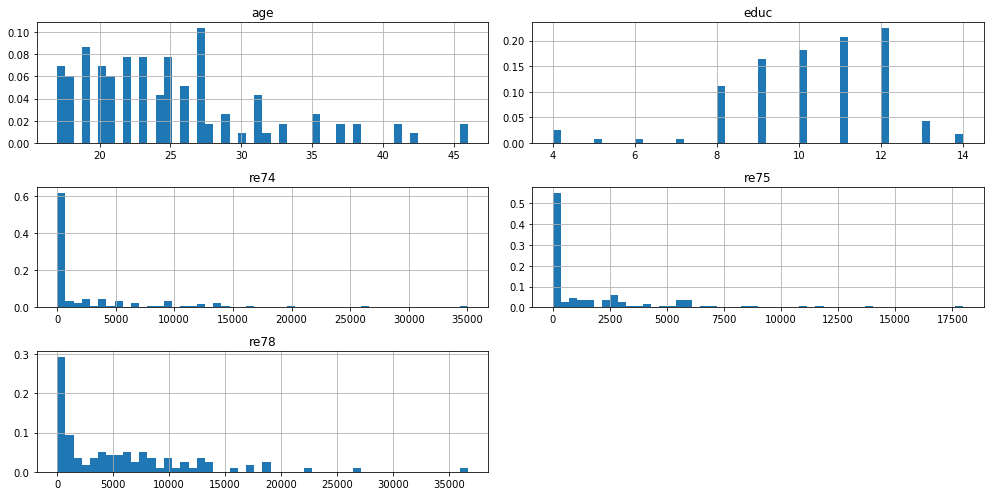

In [412]:
plotHist(treat, size=(14, 7))
plt.tight_layout()

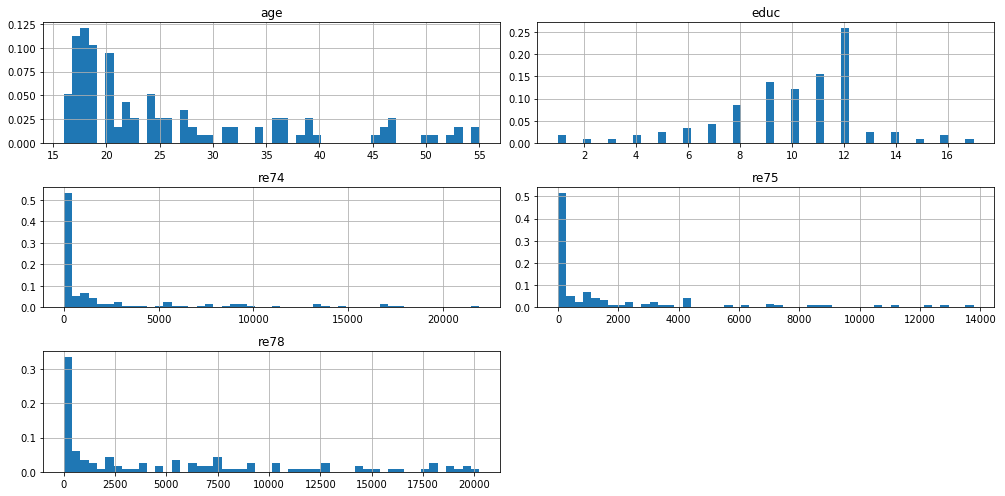

In [413]:
plotHist(control, size=(14, 7))
plt.tight_layout()

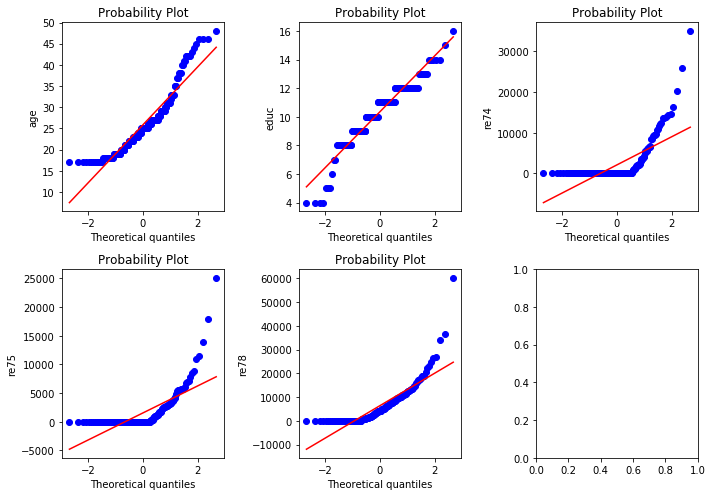

In [371]:
def qqPlots(df):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
    i = 0
    for col in df.columns:
        stats.probplot(df[col], dist="norm", plot=axes[i // 3, i % 3])
        axes[i // 3, i % 3].set_ylabel(col)
        i += 1
    plt.tight_layout()
    plt.show()

qqPlots(treat)

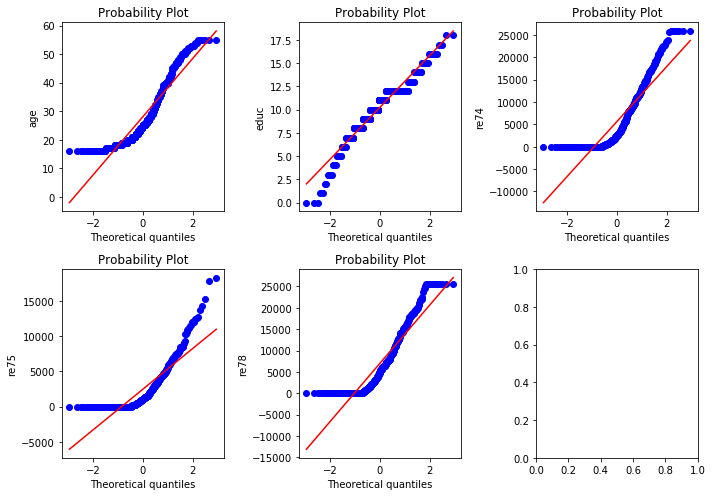

In [372]:
qqPlots(control)

In [373]:
def describeDF(df):
    desc = pd.DataFrame()
    desc['educ'] = df['educ'].describe()
    for col in df.drop('educ', 1):
        desc[col] = df[df[col] > 0][col].describe()
    return desc

describeDF(treat)

,educ,age,re74,re75,re78
count,185.000000,185.000000,54.000000,74.000000,140.000000
mean,10.345946,25.816216,7179.280230,3830.138284,8389.939665
std,2.010650,7.155019,6761.279396,4147.208703,8042.944693
min,4.000000,17.000000,445.170400,74.343450,289.789900
25%,9.000000,20.000000,2155.779000,1228.986750,3167.353750
50%,11.000000,25.000000,5465.396500,2710.460000,6504.144500
75%,12.000000,29.000000,10474.869250,5428.879500,11017.730000
max,16.000000,48.000000,35040.070000,25142.240000,60307.930000


In [374]:
describeDF(control)

,educ,age,re74,re75,re78
count,429.000000,429.000000,317.000000,295.000000,331.000000
mean,10.235431,28.030303,7604.581897,3586.853648,9051.990391
std,2.855238,10.786653,6875.777757,3427.009132,7087.340468
min,0.000000,16.000000,33.307540,10.741940,31.032260
25%,9.000000,19.000000,1579.169000,963.193550,2978.358000
50%,11.000000,25.000000,5683.833000,2565.532000,7310.313000
75%,12.000000,35.000000,11516.570000,5177.613000,14131.500000
max,18.000000,55.000000,25862.320000,18347.230000,25564.670000


In [375]:
df = df0[['treat', 'race', 'married', 'no degree']]
treat = df[df['treat'] == 1].drop('treat', 1)
control = df[df['treat'] == 0].drop('treat', 1)

However, from the analysis of categorical data it emerged that the observational study cannot be considered a 'natural experiment': it seems that black people were more likely to be treated, since they form approximately 80% of the treatment group. Conversely, the control group is composed of over 67% of white people. The treatment labeling is not random with respect to race. Moreover bachelor / married subjects are also unbalanced.

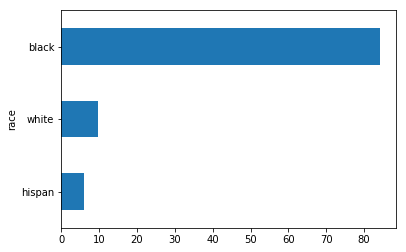

In [376]:
def plotCategories(df, cat):
    categories = df.groupby(cat).size()
    (categories.sort_values() / len(df) * 100).plot.barh()

plotCategories(treat, 'race')

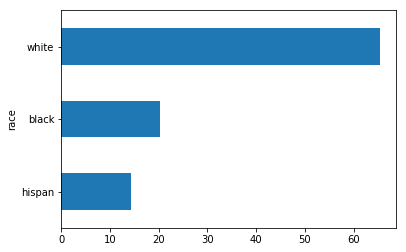

In [377]:
plotCategories(control, 'race')

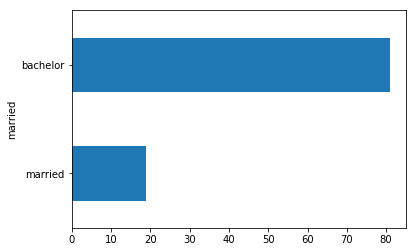

In [378]:
plotCategories(treat, 'married')

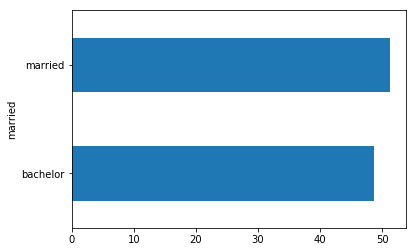

In [379]:
plotCategories(control, 'married')

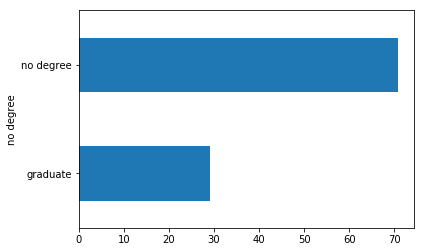

In [380]:
plotCategories(treat, 'no degree')

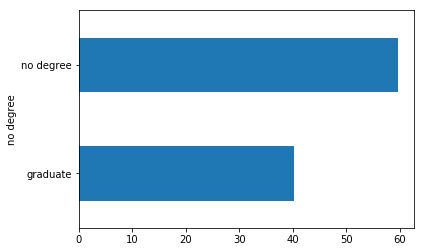

In [381]:
plotCategories(control, 'no degree')

We can repeat the analysis but this time we group subjects by race and education to rule out unobserved factors influencing the results (thus we assume that two individuals with the same race and education have the same social background). While for hispanics we do not have enough data points to conclude anything and for white people there seems to be no clear effect, it is evident that the training has been effective for working black people. There are still unobserved covariates that might influence the results, such as the will of working harder of treated subjects.

C:\Users\Michele\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


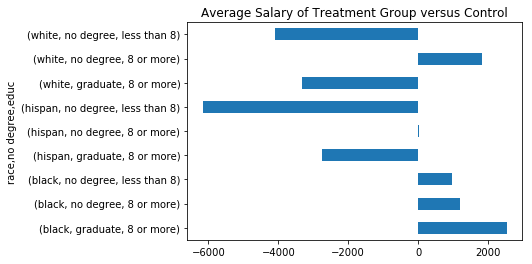

In [458]:
def diffOfSalaries(df0):
    df = df0[df0['re78'] > 0]
    df['educ'] = df.educ.map(lambda x: 'less than 8' if x < 9 else '8 or more')
    treat = df[df['treat'] == 1].drop('treat', 1)
    control = df[df['treat'] == 0].drop('treat', 1)
    avgTreat = treat.groupby(['race', 'no degree', 'educ'])['re78']
    avgControl = control.groupby(['race', 'no degree', 'educ'])['re78']
    (avgTreat.mean() - avgControl.mean()).dropna().plot.barh(title="Average Salary of Treatment Group versus Control")

diffOfSalaries(df0)

In [457]:
df0

,treat,age,educ,married,re74,re75,re78,no degree,race
id,,,,,,,,,
NSW1,1,37,11,married,0.00000,0.0000,9930.0460,no degree,black
NSW128,1,23,10,married,0.00000,936.4386,11233.2600,no degree,black
NSW119,1,19,10,bachelor,0.00000,385.2741,8124.7150,no degree,black
NSW120,1,23,12,bachelor,5506.30800,501.0741,671.3318,graduate,black
NSW121,1,29,14,bachelor,0.00000,679.6734,17814.9800,graduate,black
NSW122,1,18,10,bachelor,0.00000,798.9079,9737.1540,no degree,black
NSW123,1,19,9,bachelor,0.00000,798.9079,17685.1800,no degree,black
NSW124,1,27,13,married,9381.56600,853.7225,0.0000,graduate,white
NSW125,1,18,11,bachelor,3678.23100,919.5579,4321.7050,no degree,white


## 3. A propensity score model

In [118]:
def buildTraining(df):
    x = df.copy()
    # Categorical values decomposition
    x['married'] = x['married'].map(lambda y: 0 if y == 'bachelor' else 1)
    x['no degree'] = x['no degree'].map(lambda y: 0 if y == 'graduate' else 1)
    for r in ['black', 'white', 'hispan']:
        x[r] = x['race'].map(lambda y: 1 if y == r else 0)
    x['unemployed in 74'] = x['re74'].map(lambda y: 1 if y <= 0 else 1)
    x['unemployed in 75'] = x['re75'].map(lambda y: 1 if y <= 0 else 1)
    return x.drop('race', 1)

def compute_scores(df0):
    logistic = linear_model.LogisticRegression()
    train = buildTraining(df0.drop(['treat', 're78'], 1))
    logistic.fit(train, df0['treat'])
    return logistic.predict_proba(train)[:, 1]

## 4. Balancing the dataset via matching

The groups are now better balanced. However, there are still twice as much black people in the treatment group than in the control. We observe that bachelor vs married individuals are now well-balanced. We are still not able to observe any improvements in the treatment group.

In [191]:
import networkx as matcher

def match(df0):
    # initialization
    scores = compute_scores(df0)
    control_scores = scores[df0['treat'] == 0]
    treat_scores = scores[df0['treat'] == 1]
    graph = matcher.complete_bipartite_graph(len(treat_scores), len(control_scores))
    d = {}
    # weight edges and compute matching
    for (u, v) in graph.edges():
        d[(u, v)] = -abs(treat_scores[u] - control_scores[v - len(treat_scores)])
    matcher.set_edge_attributes(graph, 'weight', d)
    return matcher.max_weight_matching(graph, maxcardinality=True)

pairs = match(df0)

In [472]:
# Restrict dataframe to matched subjects
def buildMatchedDF(df0, pairs):
    ls = np.empty(len(df0), dtype='a16')
    ls[:] = np.nan
    for u in pairs:
        ls[u] = df0.iloc[pairs[u]].name
    df0Match = df0.copy()
    df0Match['match'] = [x.decode('utf8') for x in ls ]
    return df0Match[df0Match['match'] != 'nan']

df0Match = buildMatchedDF(df0, pairs)

In [473]:
#df = df0[df0['re78'] > 0]
df = df0
treat = df[df['treat'] == 1].drop('treat', 1)
control = df[df['treat'] == 0].drop('treat', 1)
dfMatch = df0Match.drop('match', 1)
treatMatch = dfMatch[dfMatch['treat'] == 1]
controlMatch = dfMatch[dfMatch['treat'] == 0]

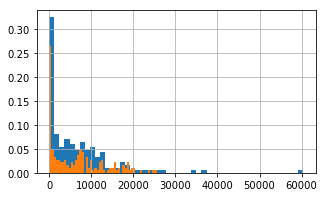

In [474]:
# The old histogram
plotHist(treatMatch['re78'])
plotHist(controlMatch['re78'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000288239FC668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000028823D65BA8>]], dtype=object)

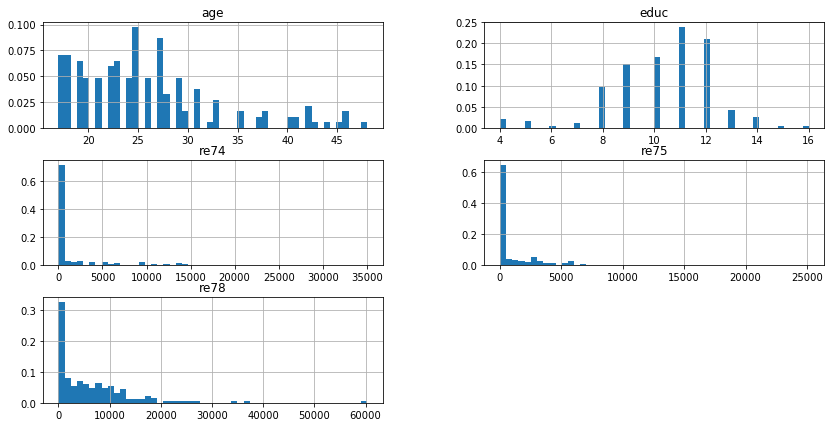

In [475]:
plotHist(treat, size=(14,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002881FCA30B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000288206D8780>]], dtype=object)

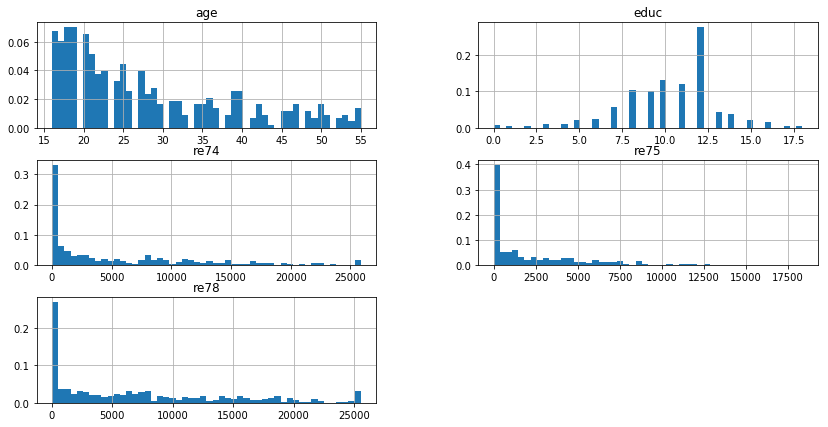

In [440]:
plotHist(control, size=(14,7))

In [441]:
dfMatch = df0Match[['treat', 'race', 'married', 'no degree']]
treat = dfMatch[dfMatch['treat'] == 1].drop('treat', 1)
control = dfMatch[dfMatch['treat'] == 0].drop('treat', 1)

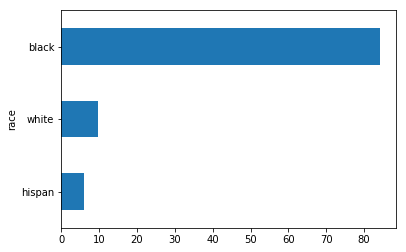

In [442]:
plotCategories(treatMatch, 'race')

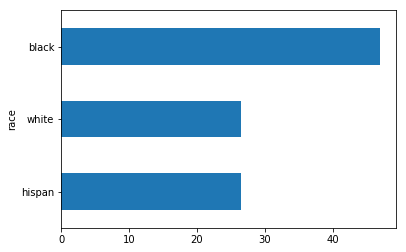

In [443]:
plotCategories(control, 'race')

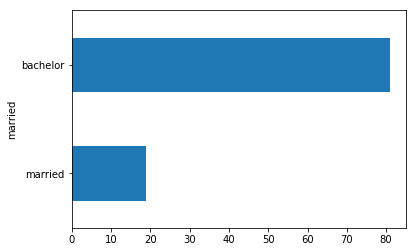

In [444]:
plotCategories(treat, 'married')

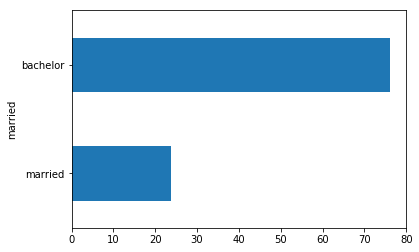

In [445]:
plotCategories(control, 'married')

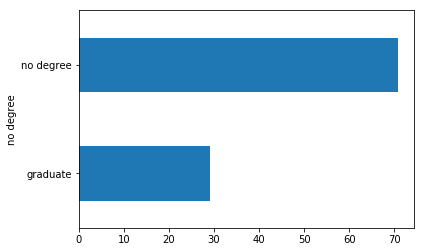

In [446]:
plotCategories(treat, 'no degree')

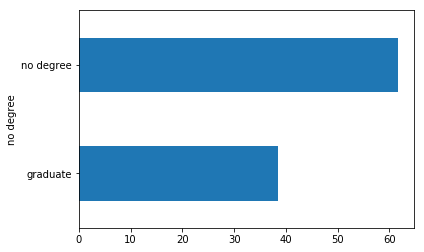

In [447]:
plotCategories(control, 'no degree')

C:\Users\Michele\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


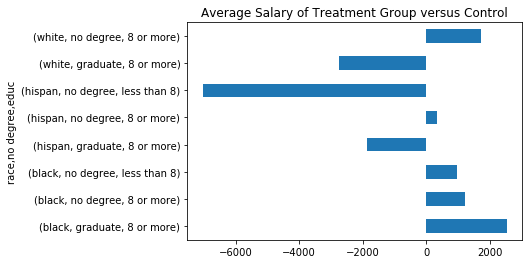

In [467]:
diffOfSalaries(df0Match)

## 5. Balancing the groups further

We split the original dataframe by race (the most troublesome feature) and then perform the same matching again. We finally merge the results again. Finally we can observe that the number of unemployed people is 5% lower in the treatment group than in the control group.

In [468]:
df0Matched2 = df0.iloc[0:0] # clearing all rows
for r in df0['race'].unique():
    df0Sub = df0[df0['race'] == r]
    df0SubMatched = buildMatchedDF(df0Sub, match(df0Sub))
    df0Matched2 = pd.merge(df0Matched2.reset_index(), 
                           df0SubMatched.reset_index(), 
                           how='outer').set_index('id')
df0Matched2 = df0Matched2.sort_values(by='treat', ascending=False)

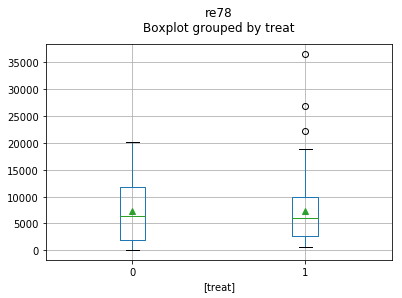

In [469]:
treat = df0Matched2[df0Matched2['treat'] == 1].drop('treat', 1)
control = df0Matched2[df0Matched2['treat'] == 0].drop('treat', 1)
boxplots(df0Matched2, 're78')

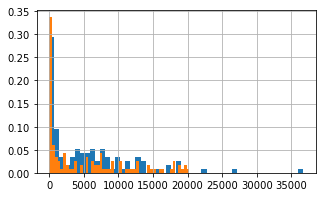

In [470]:
plotHist(treat['re78'])
plotHist(control['re78'])

In [471]:
control[['re78']].describe()

,re78
count,116.000000
mean,5259.967569
std,6167.635740
min,0.000000
25%,0.000000
50%,2283.087500
75%,8942.092750
max,20243.380000


In [409]:
treat[['re78']].describe()

,re78
count,116.000000
mean,5553.817778
std,6360.522890
min,0.000000
25%,556.907000
50%,4002.624000
75%,8096.794000
max,36646.950000
